# Introduction to dask

https://www.dask.org/

## Scaling Beyond Single-Machine Limitations

In this notebook, we'll explore:

- **Parallel Computing Fundamentals**: Understanding when and why to scale beyond pandas
- **Real-World Data Acquisition**: Downloading and processing meteorological datasets
- **Lazy Evaluation**: Dask's approach to memory-efficient large dataset processing
- **Distributed DataFrames**: Scaling pandas operations across multiple cores/machines
- **I/O Optimization**: Efficient storage strategies for large-scale data analysis

### Why Dask for High Performance Data Analysis?

Dask extends the Python data science ecosystem by providing:

1. **Familiar APIs**: Use pandas/NumPy syntax with automatic parallelization
2. **Memory Efficiency**: Process larger datasets through intelligent chunking
3. **Scalable Computing**: Scale from laptops to clusters with minimal code changes
4. **Lazy Evaluation**: Build complex computation graphs before execution
5. **Native Integration**: Seamless compatibility with existing Python data tools

### When to Choose Dask Over Pandas

**Use pandas when:**
- Dataset fits comfortably in memory (< 50% of available RAM)
- Interactive exploration and prototyping
- Complex data cleaning requiring manual inspection

**Use Dask when:**
- Dataset approaches or exceeds available memory
- Computations can be parallelized across multiple files/partitions
- Need to scale to multiple machines

In [1]:
import pathlib
import dask.dataframe
import psutil
import requests, re
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 4.48 GB


## 2. Real-World Data Acquisition 

### Automated Weather Data Collection

We'll demonstrate a realistic data acquisition scenario: downloading meteorological data from a scientific archive. This mirrors common HPDA patterns:

- **Web scraping**: Extracting file listings from HTML pages
- **Batch downloading**: Efficiently retrieving multiple files with progress monitoring  
- **Robust I/O**: Using chunked downloads to handle network interruptions

**Data Source**: Polish meteorological archive (meteo.gig.eu) - a realistic scientific dataset with multiple files requiring aggregation.

In [3]:
# using pathlib create directory called meteo
data_dir = pathlib.Path("meteo")
data_dir.mkdir(exist_ok=True)

In [4]:
base = "https://meteo.gig.eu/archiwum/2025/"
dest = pathlib.Path("meteo")
dest.mkdir(exist_ok=True)
html = requests.get(base).text
files = re.findall(r'href="([^"]+\.\w+)"', html)
for f in files:
    url = f if f.startswith("http") else base + f
    name = pathlib.Path(url).name
    print("Downloading", name)
    with requests.get(url, stream=True) as r, open(dest/name, "wb") as out:
        for chunk in r.iter_content(1024*64):
            out.write(chunk)

### Exploring Data Structure

In [5]:
first_file = next(data_dir.glob("*.txt"))
first_file

PosixPath('meteo/20250602.txt')

### Defining the Meteorological Data Schema

Our weather station data contains 36 variables covering:

- **Temperature measurements**: Indoor/outdoor, highs/lows, heat indices
- **Humidity and moisture**: Relative humidity, dew points  
- **Wind characteristics**: Speed, direction, gusts, wind chill
- **Precipitation**: Rain amounts, rates
- **Solar and UV**: Radiation measurements, UV index
- **Atmospheric pressure**: Barometric pressure readings
- **Energy calculations**: Heating/cooling degree days, evapotranspiration

In [6]:
columns = [
    "Date",
    "Time",
    "TempOut",
    "TempHi",
    "TempLow",
    "HumOut",
    "DewPt",
    "WindSpeed",
    "WindDir",
    "WindRun",
    "WindSpeedHi",
    "WindDirHi",
    "WindChill",
    "HeatIndex",
    "THWIndex",
    "THSWIndex",
    "Bar",
    "Rain",
    "RainRate",
    "SolarRad",
    "SolarEnergy",
    "SolarRadHi",
    "UVIndex",
    "UVDose",
    "UVIndexHi",
    "HeatDD",
    "CoolDD",
    "TempIn",
    "HumIn",
    "DewPtIn",
    "HeatIn",
    "ET",
    "WindSamp",
    "WindTx",
    "ISSRecept",
    "ArcInt"
]

## Single-File Processing with Pandas

### Starting with Traditional Approach

Before scaling to Dask, let's establish a baseline using pandas for single-file processing. This demonstrates:

- **Data loading with custom parameters**: Handling whitespace-delimited files, custom headers, missing values
- **Pandas flexibility**: `read_csv()` can handle complex file formats beyond simple CSV
- **Missing value strategies**: Scientific data often contains instrument failures or measurement gaps

**File Format Details**:
- **Delimiter**: Whitespace-separated values (common in scientific data)  
- **Headers**: Skip first 3 lines (metadata/headers)
- **Missing values**: Represented as `---` or `------` (instrument-specific notation)
- **Data types**: Mixed numerical data requiring type inference

### Loading and Exploring Single File

### Quick Data Quality Assessment

Examining the first few rows helps verify:
- **Data loading correctness**: Columns aligned properly, types detected correctly
- **Missing value handling**: Confirm `---` values converted to NaN
- **Data range validation**: Temperature, humidity values within expected ranges
- **Temporal structure**: Date/time columns formatted appropriately

This single-file exploration is essential before scaling to multiple files with Dask.

In [7]:
df = pd.read_csv(first_file,sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'])
df.head()

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
0,25-05-25,0:30,10.9,11.1,10.7,73,6.3,0.4,N,0.8,...,0.0,21.9,34,5.3,20.5,0.00,699,1,100.0,30
1,25-05-25,1:00,10.3,10.7,9.9,77,6.5,0.0,N,0.0,...,0.0,21.8,34,5.3,20.4,0.03,701,1,100.0,30
2,25-05-25,1:30,9.6,9.9,9.2,80,6.3,0.0,NaN,0.0,...,0.0,21.7,34,5.2,20.2,0.00,700,1,100.0,30
3,25-05-25,2:00,9.0,9.2,8.8,84,6.4,0.0,N,0.0,...,0.0,21.7,34,5.1,20.2,0.03,702,1,100.0,30
4,25-05-25,2:30,8.8,8.9,8.6,85,6.4,0.0,NaN,0.0,...,0.0,21.6,34,5.1,20.1,0.00,701,1,100.0,30


### Initial Data Visualization

Creating a scatter plot of temperature vs humidity reveals:
- **Data quality**: Are there obvious outliers or measurement errors?
- **Correlation patterns**: Expected meteorological relationships
- **Data density**: How much data do we have in this single file?

This visualization serves as our baseline for comparison when we scale to multiple files.

<Axes: xlabel='TempOut', ylabel='HumOut'>

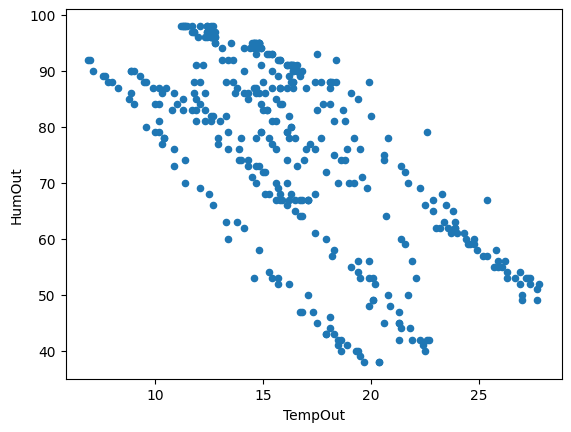

In [8]:
df.plot.scatter(x='TempOut',y='HumOut')

## Scaling Challenges: Multi-File Processing with Pandas

### The Traditional Approach and Its Limitations

When datasets span multiple files, the traditional pandas approach involves:

1. **Loop through files**: Iterate over file list sequentially  
2. **Load each file**: Use `pd.read_csv()` for each individual file
3. **Collect DataFrames**: Store results in a list
4. **Concatenate all**: Use `pd.concat()` to merge all DataFrames

### Performance and Memory Issues

This approach faces several scaling problems:

- **Memory accumulation**: All DataFrames held in memory simultaneously
- **Sequential processing**: No parallelization across files
- **Concatenation overhead**: Final merge can require 2x total dataset memory
- **No lazy evaluation**: All data loaded regardless of subsequent operations

**Real-world Impact**: For large datasets, this approach often fails with `MemoryError` or becomes prohibitively slow.

### Processing All Weather Files

In [9]:
df_list = []
for file_path in data_dir.glob("*.txt"):
    df_tmp = pd.read_csv(file_path,sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'])
    df_list.append(df_tmp)
df_all = pd.concat(df_list)
df_all.sample(10)

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
120,25-02-11,12:30,3.5,3.6,3.2,53.0,-5.2,1.8,N,3.22,...,0.000,22.7,26.0,2.2,21.3,0.00,687,1,100.0,30
66,25-06-09,9:30,13.3,13.5,13.1,78.0,9.5,2.7,N,4.83,...,0.000,23.4,43.0,10.1,22.9,0.00,699,1,100.0,30
85,25-05-05,19:00,9.1,9.2,8.9,72.0,4.3,0.9,N,1.61,...,0.000,23.4,32.0,5.7,22.4,0.00,702,1,100.0,30
25,25-06-08,13:00,16.8,16.9,16.7,90.0,15.2,0.9,N,1.61,...,0.000,24.5,47.0,12.4,24.3,0.08,703,1,100.0,30
203,25-08-14,6:00,18.7,18.9,18.6,82.0,15.6,0.0,N,0.00,...,0.008,26.7,40.0,11.9,25.9,0.00,702,1,100.0,30
117,25-09-01,11:00,21.9,22.2,21.7,78.0,17.9,0.9,N,1.61,...,0.074,26.4,43.0,12.8,25.9,0.30,698,1,100.0,30
201,25-04-10,5:00,2.4,2.6,1.9,89.0,0.8,0.9,N,1.61,...,0.000,21.0,27.0,1.3,18.8,0.00,701,1,100.0,30
42,25-09-09,4:00,14.8,14.8,14.7,95.0,14.0,0.0,N,0.00,...,0.000,20.3,50.0,9.5,19.5,0.00,701,1,100.0,30
189,25-08-13,23:00,23.9,24.2,23.5,63.0,16.4,0.4,N,0.80,...,0.116,27.8,39.0,12.6,27.1,0.05,699,1,100.0,30
221,25-09-18,15:00,18.2,18.3,18.1,73.0,13.3,0.9,N,1.61,...,0.000,24.8,41.0,10.7,24.3,0.15,700,1,100.0,30


### Data Type Analysis for Optimization

Understanding data types becomes critical when scaling:
- **Memory usage**: `object` types consume more memory than optimized types
- **Processing speed**: Numerical operations faster on native types vs objects  
- **Storage efficiency**: Type optimization crucial for I/O performance

**HPDA Strategy**: Analyze data types on small samples, then optimize for full-scale processing.

In [10]:
df_all.dtypes

Date            object
Time            object
TempOut        float64
TempHi         float64
TempLow        float64
HumOut         float64
DewPt          float64
WindSpeed      float64
WindDir         object
WindRun        float64
WindSpeedHi    float64
WindDirHi       object
WindChill      float64
HeatIndex      float64
THWIndex       float64
THSWIndex      float64
Bar            float64
Rain           float64
RainRate       float64
SolarRad       float64
SolarEnergy    float64
SolarRadHi     float64
UVIndex        float64
UVDose         float64
UVIndexHi      float64
HeatDD         float64
CoolDD         float64
TempIn         float64
HumIn          float64
DewPtIn        float64
HeatIn         float64
ET             float64
WindSamp         int64
WindTx           int64
ISSRecept      float64
ArcInt           int64
dtype: object

### Visualization with Larger Dataset

Notice the increased point density and clearer patterns with more data:
- **Statistical power**: More data points reveal clearer relationships  
- **Seasonal patterns**: Multiple months show temperature/humidity cycles
- **Outlier identification**: Unusual measurements become visible

**Performance Note**: The `s=1` parameter reduces marker size, improving rendering performance with large datasets.

<Axes: xlabel='TempOut', ylabel='HumOut'>

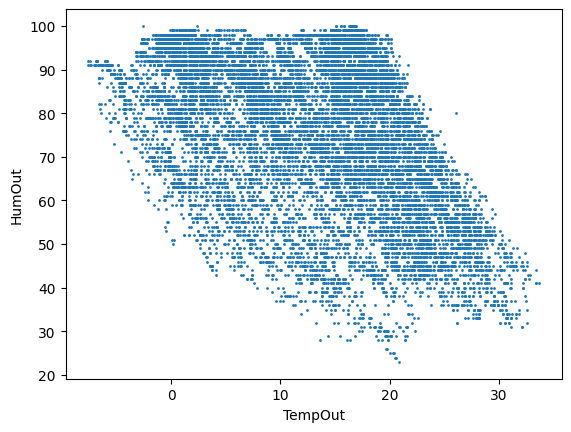

In [11]:
df_all.plot.scatter(x='TempOut',y='HumOut', s=1)

In [12]:
df_dask = dask.dataframe.read_csv(
    data_dir/"*.txt", sep=r'\s+', names=columns, skiprows=3, na_values=['---', '------'], assume_missing=True
)

# Fill missing integer columns with -1 and cast to int after loading
for col in ['HumIn', 'HumOut', 'SolarRad', 'SolarRadHi']:
   df_dask[col] = df_dask[col].fillna(-1).astype('int64')

## Dask DataFrames - Parallel Computing for Large Datasets

### The Dask Advantage: Lazy Evaluation and Parallel Processing

Dask features:

1. **Lazy evaluation**: Operations build computation graphs without immediate execution
2. **Automatic partitioning**: Files processed in parallel across available cores
3. **Memory efficiency**: Only required partitions loaded into memory
4. **Familiar API**: Same pandas operations with distributed execution

### Key Dask Concepts

- **Task Graph**: Dask builds a graph of operations before execution
- **Partitions**: Data split across multiple processing units
- **Workers**: Parallel processes executing computations
- **Scheduler**: Coordinates task execution and memory management

### Loading Multiple Files with Dask

The `read_csv()` with wildcard pattern `*.txt` automatically:
- **Discovers all matching files** in parallel
- **Creates partitioned DataFrame** with one partition per file (or optimized chunks)
- **Maintains lazy evaluation** - no data loaded until `.compute()` called
- **Handles schema inference** across all files

### Dask Operations: Lazy Evaluation in Action

This operation demonstrates Dask's lazy evaluation:

1. **`.unique()`**: Creates task to find unique values in HumOut column
2. **`.min()`**: Adds task to find minimum of unique values  
3. **`.compute()`**: **Only now** does Dask execute the computation graph

**Key Advantage**: Complex operation chains are optimized before execution, eliminating intermediate results and optimizing memory usage.

**Performance Comparison**: This lazy approach can be 10-100x more memory efficient than equivalent pandas operations on large datasets.

In [13]:
df_dask.HumOut.unique().min().compute()

np.float64(-1.0)

### Converting Dask to Pandas for Visualization

The `.compute()` method triggers execution and returns a pandas DataFrame:

**When to use `.compute()`:**
- **Final results**: When you need actual data (plotting, final analysis)
- **Small results**: When result fits comfortably in memory
- **Interactive exploration**: For immediate feedback

**When to avoid `.compute()`:**
- **Large intermediate results**: Keep computation lazy as long as possible
- **Chained operations**: Let Dask optimize the entire pipeline
- **Exploratory analysis**: Use Dask's lazy operations for initial filtering

**Memory Management**: Always ensure `.compute()` results fit in available memory!

<Axes: xlabel='TempOut', ylabel='HumOut'>

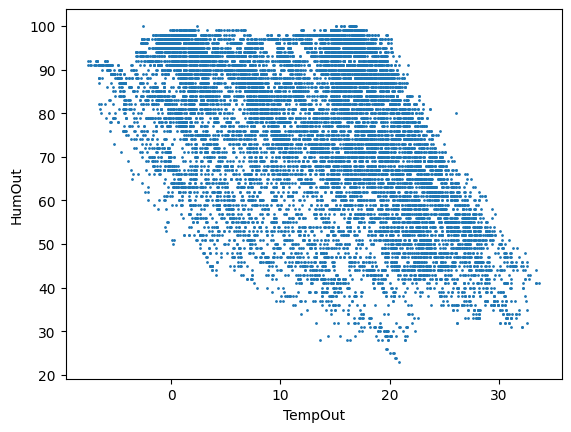

In [14]:
df_dask.compute().plot.scatter(x='TempOut',y='HumOut', s=1)

## High-Performance Data Storage Strategies

### HDF5: The Gold Standard for Scientific Data

HDF5 (Hierarchical Data Format 5) is optimal for HPDA workflows because:

- **Binary format**: Much faster I/O than text-based formats (CSV, JSON)
- **Hierarchical structure**: Organize related datasets in single file
- **Metadata support**: Store data descriptions, units
- **Cross-platform**: Same format works on Windows, Linux, macOS
- **Chunking**: Optimized for partial data access patterns
- **Compression**: Built-in compression algorithms

### Storage Comparison: Uncompressed HDF5

Let's compare storage efficiency with our baseline approach:

In [15]:
dask_out_path = data_dir/"meteo_dask.h5"
df_dask.to_hdf(dask_out_path, key='df', mode='w');

# print size of the created file
print(f"Size of the created file: {dask_out_path.stat().st_size / (1024**2):.2f} MB")

Size of the created file: 4.01 MB


### Storage Optimization: Compression Strategies

The `complevel=5` parameter applies medium-strength compression:

**Compression Levels (0-9):**
- **Level 0**: No compression (fastest write/read)
- **Level 1-3**: Light compression (good balance for frequent access)
- **Level 5**: Medium compression (optimal for most HPDA workflows)  
- **Level 9**: Maximum compression (best for archival storage)

**Trade-offs:**
- **Higher compression**: Smaller file size, slower read/write
- **Lower compression**: Larger file size, faster read/write

**HPDA Rule of Thumb**: Use level 5 for working datasets, level 9 for long-term storage.

In [16]:
df_dask.to_hdf(dask_out_path, key='df', mode='w', complevel=5);
print(f"Size of the created file: {dask_out_path.stat().st_size / (1024**2):.2f} MB")

Size of the created file: 0.76 MB


## Advanced Challenges

### 🚀 **Challenge 1: Historical Data Extension**

**Objective**: Extend the analysis to include data from 2006 to present day.

**Technical Considerations**:
- **Data volume**: 19+ years of hourly data ≈ millions of records
- **Schema evolution**: Column names/formats may have changed over time
- **Missing data patterns**: Different instruments, maintenance periods

**Implementation Strategy**:
```python
# TODO: Extend data range
# base_urls = [
#     "https://meteo.gig.eu/archiwum/2006/",
#     "https://meteo.gig.eu/archiwum/2007/",
#     # ... continue through 2025
# ]
```

**Learning Objectives**:
- Experience real-world data heterogeneity
- Practice robust web scraping patterns
- Understand temporal data partitioning strategies
- Learn chunk-wise processing techniques

### 🧮 **Challenge 2: Data Type Optimization**

**Objective**: Optimize memory usage through intelligent data type selection.

**Current Issues**:
- Many columns stored as `object` type (memory inefficient)
- Date/Time columns need proper temporal types
- Categorical variables (WindDir) should use `category` dtype
- Some integer columns could use smaller bit widths

**Optimization Strategies**:

1. **Categorical Types**: Convert wind direction, weather conditions
```python
# TODO: Implement categorical optimization
# df_dask['WindDir'] = df_dask['WindDir'].astype('category')
```

2. **Temporal Types**: Proper datetime handling
```python
# TODO: Implement datetime parsing
# df_dask['DateTime'] = dd.to_datetime(df_dask['Date'] + ' ' + df_dask['Time'])
```

3. **Numerical Optimization**: Use appropriate bit widths
```python
# TODO: Optimize integer types
# df_dask['HumOut'] = df_dask['HumOut'].astype('int8')  # 0-100 range
```

**Expected Results**:
- 30-50% memory reduction
- Faster categorical operations
- Improved temporal analysis capabilities
- Better compression ratios in storage

**Performance Measurement**:
Compare memory usage, file sizes, and operation speeds before/after optimization.

### 🎯 **Bonus Challenge: Advanced Analytics**

**Time Series Analysis**: Calculate rolling averages, seasonal decomposition
**Correlation Studies**: Multi-variable relationships across temporal patterns
**Anomaly Detection**: Identify unusual weather patterns or sensor failures
**Predictive Modeling**: Use historical data to forecast future conditions

### 📊 **Key Takeaways**

1. **Progressive Scaling**: Start with pandas, migrate to Dask when needed
2. **Lazy Evaluation**: Build computation graphs before execution
3. **Storage Strategy**: Choose formats and compression levels strategically  
4. **Data Types**: Optimize memory through appropriate type selection
5. **Partitioning**: Design data organization for parallel access patterns